# Crop Yield Prediction: XGBoost with Optuna (Weighted RMSE)

## Overview
This notebook trains an **XGBoost (Extreme Gradient Boosting)** model to predict crop yields. 

**Important Change:** The evaluation metric and training objective have been updated to use **Weighted RMSE**. The model weights samples based on the production quantity (`Value`) provided in `df2` (Production Data). This ensures that countries/areas with higher production volumes have a larger influence on the model's accuracy.

## Methodology
1.  **Crop Selection & Weighting:** Choose the crop and merge production weights.
2.  **Feature Analysis:** Review input variables.
3.  **Time-Series Split:** Divide data by year, ensuring weights align with splits.
4.  **Baseline:** Compare against a simple guess (Last Year's Yield) using Weighted RMSE.
5.  **Initial Model:** Train a default model using sample weights.
6.  **Optimization:** Use **Optuna** to find settings that minimize Weighted RMSE.
7.  **Final Evaluation:** Compare accuracy across stages.

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

/Users/pavin/Documents/GitHub/ML_project/Final/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df2 = pd.read_csv('Data/production.csv')
df2 = df2.drop(columns=[col for col in df2.columns if col not in ['Area', 'Value']])
df2['Value'] = df2['Value'].fillna(0)

# Print general status / summary
print(df2.info())
print(df2.head())
print(df2.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    144 non-null    object 
 1   Value   144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB
None
          Area       Value
0  Afghanistan   597000.00
1      Albania        0.00
2      Algeria      307.29
3       Angola    39830.00
4    Argentina  1163209.00
              Value
count  1.440000e+02
mean   7.000442e+06
std    3.050605e+07
min    0.000000e+00
25%    1.548640e+03
50%    1.352423e+05
75%    1.374185e+06
max    2.080642e+08


### 1. Data Preparation and Crop Choice
We load the main dataset and identify the available crops. For this analysis, we focus specifically on **Rice**.

**Weight Integration:** We merge the 'Value' column from `df2` (Production) into our main dataframe based on 'Area'. This column will be used as the **Sample Weight** for training and evaluation.

In [6]:
# Load dataset
df = pd.read_parquet('Parquet/XY_v3.parquet')

# Make sure both columns have the same case
df_area_set = df['area'].unique()  # get unique areas from df

# Keep only rows in df2 where Area matches df['area']
df2 = df2[df2['Area'].isin(df_area_set)]

# Check result
print(df2.info())
print(df2.head())
print(df2.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    100 non-null    object 
 1   Value   100 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ KB
None
          Area       Value
0  Afghanistan   597000.00
1      Albania        0.00
2      Algeria      307.29
3       Angola    39830.00
4    Argentina  1163209.00
              Value
count  1.000000e+02
mean   7.147655e+06
std    3.019277e+07
min    0.000000e+00
25%    1.182250e+04
50%    1.703750e+05
75%    1.200657e+06
max    2.080642e+08


In [7]:
# --- LIST AVAILABLE CROPS ---
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("--- Available Crops found in Dataset ---")
print(available_crops)
print("-" * 40)

# --- CONFIGURATION: SET CROP HERE ---
CHOSEN_CROP = 'rice'

# Define Target and Dynamic Lag Features
TARGET_COL = f'Y_{CHOSEN_CROP}'
LAG_1_FEATURE = f'avg_yield_{CHOSEN_CROP}_1y'

if TARGET_COL not in df.columns:
    raise ValueError(f"Target {TARGET_COL} not found in dataset. Check spelling.")

print(f"Predicting Target: {TARGET_COL}")

# --- INTEGRATE WEIGHTS ---
# Prepare weights from df2. We use 'Value' as the weight.
weights_df = df2[['Area', 'Value']].rename(columns={'Area': 'area', 'Value': 'sample_weight'})

# Merge weights into main dataframe
df = df.merge(weights_df, on='area', how='left')

# Fill missing weights with 1.0 (or median/mean) to ensure calculation stability
df['sample_weight'] = df['sample_weight'].fillna(1.0)

# Clean Missing Targets for the chosen crop
df_model = df.dropna(subset=[TARGET_COL])

print(f"Data Loaded. Rows with valid target: {len(df_model)}")
print("Sample Weights loaded from Production Value.")

--- Available Crops found in Dataset ---
['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
----------------------------------------
Predicting Target: Y_rice
Data Loaded. Rows with valid target: 4729
Sample Weights loaded from Production Value.


### 2. Selecting Features and Splitting Data
We identify the input variables. Crucially, we extract the `sample_weight` for every split (Train, Validation, Test) so that all RMSE calculations account for the production volume.

In [8]:
# --- DROP UNWANTED COLUMNS ---
cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and CHOSEN_CROP not in c]

df_model = df_model.drop(columns=cols_to_drop)

# --- FEATURE SELECTION ---
# Select independent variables (exclude 'Y_' columns, metadata, and the weight column from X)
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['area', 'sample_weight']]

print(f"Total Features Used: {len(feature_cols)}")
display(pd.DataFrame(feature_cols, columns=['Feature Name']).T)

# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

# 1. Training Set (< 2014)
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]
w_train = df_model[mask_train]['sample_weight']  # Weights for training

# 2. Validation Set (2014-2018)
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]
w_val = df_model[mask_val]['sample_weight']      # Weights for validation

# 3. Test Set (>= 2019)
mask_test = df_model['year'] >= VAL_END_YEAR
X_test = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]
w_test = df_model[mask_test]['sample_weight']    # Weights for testing

print(f"\nTraining Samples: {len(X_train)}")
print(f"Validation Samples: {len(X_val)}")
print(f"Testing Samples: {len(X_test)}")

Total Features Used: 17


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Feature Name,year,avg_yield_rice_1y,avg_yield_rice_2y,avg_yield_rice_3y,rain_annual,rain_sin,rain_cos,solar_annual,solar_sin,solar_cos,temp_annual,temp_sin,temp_cos,pesticides_lag1,fertilizer_lag1,latitude,longitude



Training Samples: 3579
Validation Samples: 575
Testing Samples: 575


In [9]:
X_train.head()

,year,avg_yield_rice_1y,avg_yield_rice_2y,avg_yield_rice_3y,rain_annual,rain_sin,rain_cos,solar_annual,solar_sin,solar_cos,temp_annual,temp_sin,temp_cos,pesticides_lag1,fertilizer_lag1,latitude,longitude
0,1982,2241.4,2207.10,2181.766667,325.32,154.391016,59.402942,NaN,NaN,NaN,11.699167,-33.899342,-60.110408,NaN,5.778887,34.53,69.17
1,1983,2199.4,2220.40,2204.533333,373.54,186.787027,72.870980,NaN,NaN,NaN,10.650833,-42.640609,-60.922614,NaN,6.672946,34.53,69.17
2,1984,2258.1,2228.75,2232.966667,273.25,211.709895,-21.830163,NaN,NaN,NaN,11.383333,-46.025539,-55.929678,NaN,7.152971,34.53,69.17
3,1985,2241.6,2249.85,2233.033333,196.10,96.438281,33.467341,19.215833,-13.475498,-51.480910,11.888333,-39.599910,-69.677748,NaN,9.178255,34.53,69.17
4,1986,2248.2,2244.90,2249.300000,155.09,67.530475,38.964517,18.741667,-12.861915,-47.249218,12.511667,-31.144849,-60.631870,NaN,9.224020,34.53,69.17


### 3. Setting a Baseline (Weighted)
We calculate the **Weighted RMSE** for the baseline (Last Year's Yield). This accounts for the fact that errors in high-production areas are more costly than errors in low-production areas.

In [10]:
# Baseline: yield(t) = yield(t-1)
y_pred_baseline = X_test[LAG_1_FEATURE]

# Clean NaNs for metric calculation (ensure weights align)
mask_valid = ~y_pred_baseline.isna() & ~y_test.isna()
y_test_clean = y_test[mask_valid]
y_pred_clean = y_pred_baseline[mask_valid]
w_test_clean = w_test[mask_valid]

# --- WEIGHTED RMSE CALCULATION ---
rmse_baseline = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean, sample_weight=w_test_clean))
r2_baseline = r2_score(y_test_clean, y_pred_clean, sample_weight=w_test_clean)

print(f"Baseline Weighted RMSE: {rmse_baseline:.2f}")

Baseline Weighted RMSE: 139.49


### 4. Initial Model Testing (Weighted Training)
We train XGBoost passing `sample_weight` to the fit function. This forces the trees to focus more on minimizing error for high-value rows.

[0]	validation_0-rmse:1546.11268	validation_1-rmse:1748.38858
[100]	validation_0-rmse:59.76142	validation_1-rmse:187.29890
[143]	validation_0-rmse:50.19025	validation_1-rmse:188.55782


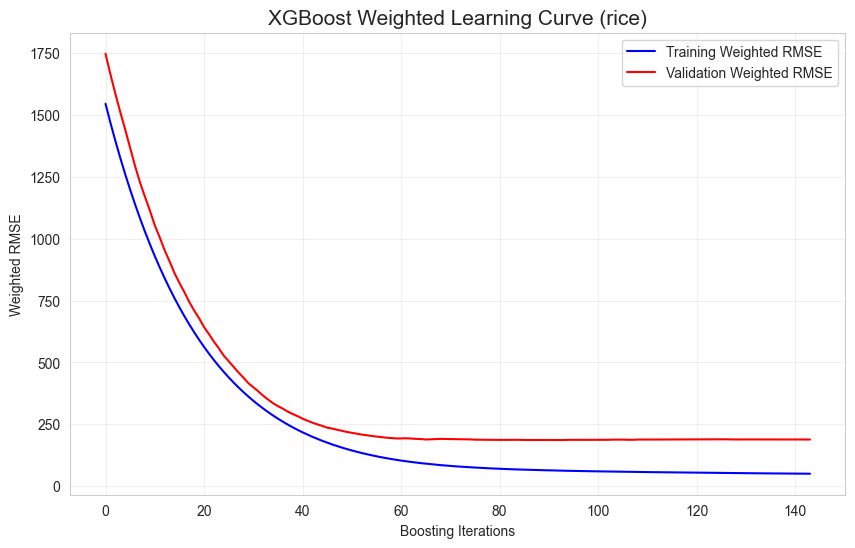

Initial Model Test Weighted RMSE: 295.73


In [11]:
# --- INITIAL MODEL TRAINING WITH WEIGHTS ---

model_init = xgb.XGBRegressor( 
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=6,
    random_state=42, 
    n_jobs=-1,
    early_stopping_rounds=50
)

# Fit using weights
model_init.fit(
    X_train, y_train,
    sample_weight=w_train,  # <--- Apply weights during training
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    sample_weight_eval_set=[w_train, w_val], # <--- Apply weights to eval metrics
    verbose=100
)

results = model_init.evals_result()

# --- PLOT LEARNING CURVE ---
def plot_learning_curve(results, metric='rmse'):
    plt.figure(figsize=(10, 6))
    train_metric = results['validation_0'][metric]
    val_metric = results['validation_1'][metric]
    plt.plot(train_metric, label='Training Weighted RMSE', color='blue')
    plt.plot(val_metric, label='Validation Weighted RMSE', color='red')
    plt.title(f'XGBoost Weighted Learning Curve ({CHOSEN_CROP})', fontsize=15)
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Weighted RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curve(results)

# Evaluate on TEST Set
y_pred_init_test = model_init.predict(X_test)

# Weighted Test RMSE
rmse_init_test = np.sqrt(mean_squared_error(y_test, y_pred_init_test, sample_weight=w_test))
print(f"Initial Model Test Weighted RMSE: {rmse_init_test:.2f}")

### 5. Tuning the Model (Optuna with Weighted Objective)
The Optuna objective function is updated to optimize for **Weighted RMSE** on the validation set.

In [12]:
def objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'early_stopping_rounds': 30
    }

    model = xgb.XGBRegressor(**params)
    
    # Train with Weights
    model.fit(
        X_train, y_train,
        sample_weight=w_train,
        eval_set=[(X_val, y_val)],
        sample_weight_eval_set=[w_val],
        verbose=False
    )
    
    preds = model.predict(X_val)
    
    # Optimize Weighted RMSE
    rmse = np.sqrt(mean_squared_error(y_val, preds, sample_weight=w_val))
    return rmse

# --- RUN OPTIMIZATION ---
study_name = f'{CHOSEN_CROP.capitalize()}_Weighted_Yield_XGBoost'
study = optuna.create_study(direction='minimize', study_name=study_name)
study.optimize(objective, n_trials=50)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-12-05 17:42:40,097] A new study created in memory with name: Rice_Weighted_Yield_XGBoost
[I 2025-12-05 17:42:40,615] Trial 0 finished with value: 243.3037823625764 and parameters: {'learning_rate': 0.07268208573477003, 'max_depth': 11, 'min_child_weight': 8, 'subsample': 0.7337202343187958, 'colsample_bytree': 0.7480877795503088, 'reg_alpha': 0.6136525421143658, 'reg_lambda': 3.654445020137867}. Best is trial 0 with value: 243.3037823625764.
[I 2025-12-05 17:42:41,039] Trial 1 finished with value: 201.44069180443202 and parameters: {'learning_rate': 0.018691720897463335, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.6277662163182589, 'colsample_bytree': 0.33526864476809876, 'reg_alpha': 0.18783728942322012, 'reg_lambda': 0.0398462143805636}. Best is trial 1 with value: 201.44069180443202.
[I 2025-12-05 17:42:42,749] Trial 2 finished with value: 178.07775438595638 and parameters: {'learning_rate': 0.01413276829659646, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 


Best Parameters found:
{'learning_rate': 0.04136159598622724, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7245451386680889, 'colsample_bytree': 0.5510282123978605, 'reg_alpha': 0.0547000268773613, 'reg_lambda': 1.4953672919499852}


### 6. Visualizing Optimization

In [13]:
name = f"{CHOSEN_CROP.capitalize()}_Yield_Model"

fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
fig.show()

fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
fig.show()

### 7. Final Model Training (Weighted)
We combine Train and Validation sets (and their weights) to train the final model.

In [14]:
# 1. Combine Train + Validation (Features, Targets, and Weights)
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])
w_train_full = pd.concat([w_train, w_val])

# 2. Initialize with Best Params
best_params = study.best_params
best_params['n_estimators'] = 1000
best_params['random_state'] = 42
best_params['n_jobs'] = -1
best_params['early_stopping_rounds'] = 50

final_model = xgb.XGBRegressor(**best_params)

# 3. Train on Full History with Weights
final_model.fit(
    X_train_full, y_train_full,
    sample_weight=w_train_full,
    eval_set=[(X_train_full, y_train_full), (X_test, y_test)],
    sample_weight_eval_set=[w_train_full, w_test],
    verbose=100
)

# 4. Final Prediction
y_pred_final_test = final_model.predict(X_test)
rmse_final_test = np.sqrt(mean_squared_error(y_test, y_pred_final_test, sample_weight=w_test))
r2_final_test = r2_score(y_test, y_pred_final_test, sample_weight=w_test)

[0]	validation_0-rmse:1585.53051	validation_1-rmse:1803.76821
[100]	validation_0-rmse:135.90645	validation_1-rmse:152.27018
[200]	validation_0-rmse:114.79240	validation_1-rmse:140.14455
[283]	validation_0-rmse:106.44660	validation_1-rmse:141.46774


### 8. Results and Analysis
We evaluate the final performance using **Weighted RMSE**.

--- Final Performance Report (Test Set - Weighted) ---
Baseline Weighted RMSE: 139.49, R2=0.9920
Initial Model Weighted RMSE: 295.73
Tuned Model Weighted RMSE: 139.14, R2=0.9920 (Improved 0.26%)


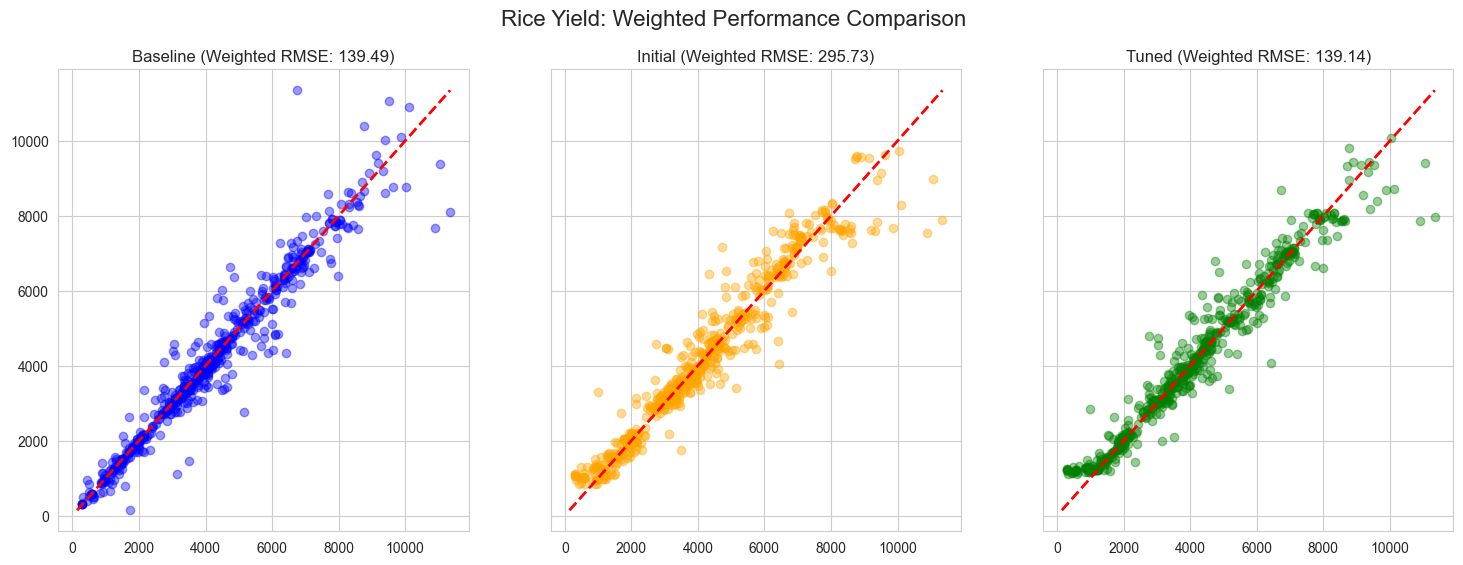

In [15]:
# Calculate Improvement %
imp_final = (rmse_baseline - rmse_final_test) / rmse_baseline * 100

print("--- Final Performance Report (Test Set - Weighted) ---")
print(f"Baseline Weighted RMSE: {rmse_baseline:.2f}, R2={r2_baseline:.4f}")
print(f"Initial Model Weighted RMSE: {rmse_init_test:.2f}")
print(f"Tuned Model Weighted RMSE: {rmse_final_test:.2f}, R2={r2_final_test:.4f} (Improved {imp_final:.2f}%)")

# --- PLOTTING RESULTS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

all_preds = np.concatenate([y_pred_clean, y_pred_init_test, y_pred_final_test])
all_true = np.concatenate([y_test_clean, y_test, y_test])
min_val, max_val = min(min(all_preds), min(all_true)), max(max(all_preds), max(all_true))

axes[0].scatter(y_test_clean, y_pred_clean, alpha=0.4, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Baseline (Weighted RMSE: {rmse_baseline:.2f})')

axes[1].scatter(y_test, y_pred_init_test, alpha=0.4, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Initial (Weighted RMSE: {rmse_init_test:.2f})')

axes[2].scatter(y_test, y_pred_final_test, alpha=0.4, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[2].set_title(f'Tuned (Weighted RMSE: {rmse_final_test:.2f})')

plt.suptitle(f'{CHOSEN_CROP.capitalize()} Yield: Weighted Performance Comparison', fontsize=16)
plt.show()

### 9. Trend Analysis & Geographic Error

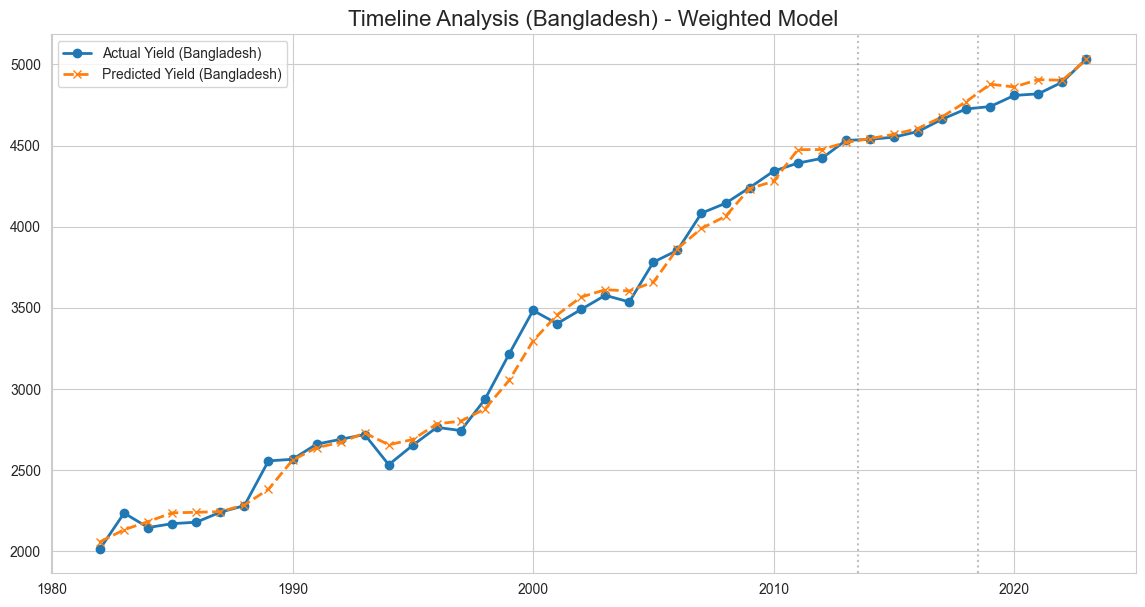

In [16]:
# Country parameter
TARGET_COUNTRY = "Bangladesh"

# Generate Predictions on full dataset
all_predictions = final_model.predict(df_model[feature_cols])

# Create DataFrame WITH AREA column
df_full_trend = pd.DataFrame({
    'Year': df_model['year'],
    'Area': df_model['area'], 
    'Actual': df_model[TARGET_COL],
    'Predicted': all_predictions
})

# Filter for Target Country
df_th = df_full_trend[df_full_trend['Area'] == TARGET_COUNTRY]
yearly_trend = df_th.groupby('Year')[['Actual', 'Predicted']].mean()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(yearly_trend.index, yearly_trend['Actual'], marker='o', label=f'Actual Yield ({TARGET_COUNTRY})', linewidth=2)
plt.plot(yearly_trend.index, yearly_trend['Predicted'], marker='x', linestyle='--', label=f'Predicted Yield ({TARGET_COUNTRY})', linewidth=2)

# Draw Split lines
plt.axvline(TRAIN_END_YEAR - 0.5, color='grey', linestyle=':', alpha=0.5)
plt.axvline(VAL_END_YEAR - 0.5, color='grey', linestyle=':', alpha=0.5)

plt.title(f'Timeline Analysis ({TARGET_COUNTRY}) - Weighted Model', fontsize=16)
plt.legend()
plt.show()

In [17]:
import plotly.express as px

# Create Comparison DF
test_context = df_model[mask_test][['area', 'year']]
comparison_df = pd.DataFrame({
    'Actual_Value': y_test,
    'Predicted_Value': y_pred_final_test
}).join(test_context)

# Calculate Errors
comparison_df['Squared_Error'] = (comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) ** 2

# Aggregate RMSE by Country
rmse_df = (
    comparison_df.groupby('area')['Squared_Error']
    .mean()
    .apply(np.sqrt)
    .reset_index()
    .rename(columns={'area': 'Country', 'Squared_Error': 'RMSE'})
)

# Map
fig = px.choropleth(
    rmse_df,
    locations='Country',
    color='RMSE',
    locationmode='country names',
    color_continuous_scale=['green', 'yellow', 'red'],
    title='Geographic Error Distribution (Weighted Model Training)'
)
fig.show()

/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_15160/2320511588.py:23: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



### 10. Feature Importance


--- Top 10 Most Important Features (Text Report) ---
             Feature  Importance
0  avg_yield_rice_2y    0.316194
1           latitude    0.225357
2  avg_yield_rice_1y    0.220069
3  avg_yield_rice_3y    0.180754
4    fertilizer_lag1    0.028703
5        rain_annual    0.011100
6               year    0.004055
7           rain_cos    0.002763
8       solar_annual    0.002446
9           temp_sin    0.001517


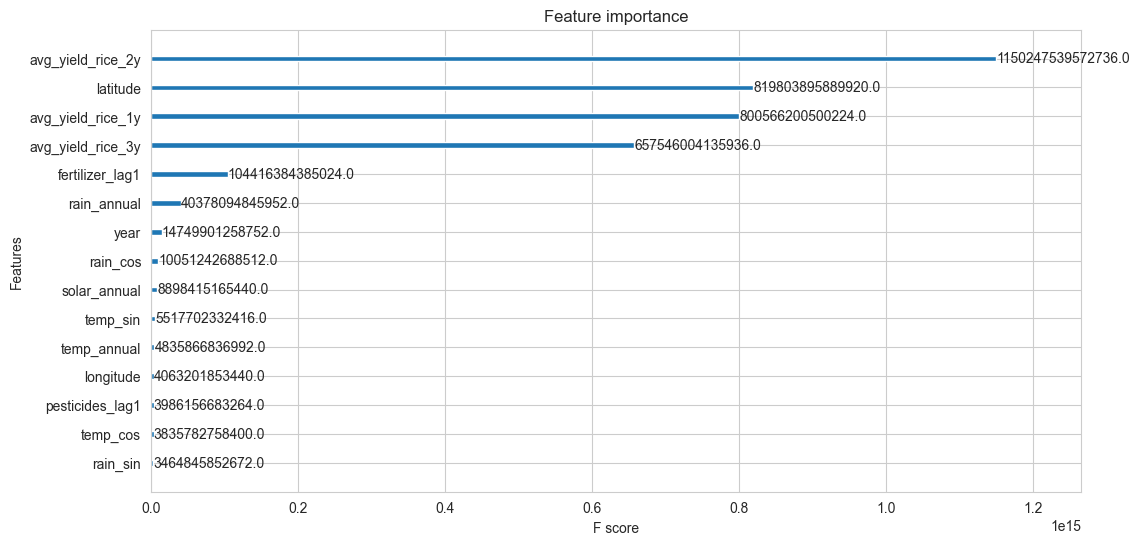

In [18]:
importances = final_model.feature_importances_
feature_names = final_model.feature_names_in_

fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("\n--- Top 10 Most Important Features (Text Report) ---")
print(fi_df.head(10))

xgb.plot_importance(final_model, max_num_features=15, importance_type='gain')
plt.show()